In [1]:
from lemaitre import georges
georges.setup_logger(level='INFO')
from lemaitre import bandpasses

filterlib = bandpasses.get_filterlib()

2025-05-15 10:59:52 INFO lemaitre.bandpasses.flibs - loading lemaitre filterlib from /home/okc/.cache/bbf/lemaitre_flib.default.44fa250da9a1f29e6032255a6f85739144004c18874eca1d1317696bbce56e78.pkl


In [2]:
import skysurvey
import numpy as np
import sncosmo
import pandas
from src import *
from tqdm.auto import tqdm
import jax.numpy as jnp
import pickle

2025-05-15 10:59:52 INFO lemaitre.bandpasses.flibs - loading lemaitre filterlib from /home/okc/.cache/bbf/lemaitre_flib.default.44fa250da9a1f29e6032255a6f85739144004c18874eca1d1317696bbce56e78.pkl
2025-05-15 10:59:53 INFO arviz.preview - arviz_base not installed
2025-05-15 10:59:53 INFO arviz.preview - arviz_stats not installed
2025-05-15 10:59:53 INFO arviz.preview - arviz_plots not installed
INFO:2025-05-15 10:59:53,763:jax._src.xla_bridge:924: Unable to initialize backend 'cuda': 
2025-05-15 10:59:53 INFO jax._src.xla_bridge - Unable to initialize backend 'cuda': 
INFO:2025-05-15 10:59:53,764:jax._src.xla_bridge:924: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2025-05-15 10:59:53 INFO jax._src.xla_bridge - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-05-15 10:59:53,771:jax._src.xla_bridge:924: Unable to initialize backend 'tpu': INTERNAL: Failed to open 

In [3]:
import warnings
from iminuit.warnings import IMinuitWarning

warnings.filterwarnings("ignore", category=IMinuitWarning)

In [4]:
%matplotlib inline

In [5]:
survey_colors = dict(ZTF="tab:blue", SNLS="tab:orange", HSC="tab:green")

## 2M++ halos loading

When drawing from the 2M++ grid, enforce z_max=0.11677 otherwise it's not isotrope 

In [6]:
z_max = 0.11677295
from astropy.cosmology import FlatLambdaCDM

cosmo = FlatLambdaCDM(name="2m++", H0=68.1, Om0=0.306)

In [7]:
from scipy.interpolate import interp1d

dc_to_z = interp1d(
    cosmo.comoving_distance(np.linspace(1e-4, 0.5, 10000)),
    np.linspace(1e-4, 0.5, 10000),
)

##### First loading

In [13]:
import h5py

In [124]:
with h5py.File("./data/reduced_hbt/mcmc_0.hdf5", "r") as file:
    print("Keys: %s" % file.keys())
    print(list(file["Subhalos"]))
    cosmo_params = {
        params: np.array(file["Cosmology"][params])[0]
        for params in list(file["Cosmology"])
    }
    positions = np.array(file["Subhalos"]["ComovingAveragePosition"])
    positions_mostbound = np.array(file["Subhalos"]["ComovingMostBoundPosition"])
    masses = np.array(file["Subhalos"]["BoundM200Crit"])
    radius = np.array(file["Subhalos"]["BoundR200CritComoving"])
    velocities = np.array(file["Subhalos"]["PhysicalAverageVelocity"])
    ids = np.array(file["Subhalos"]["HostHaloId"])
    rmax = np.array(file["Subhalos"]["RmaxComoving"])
    vmax = np.array(file["Subhalos"]["VmaxPhysical"])

Keys: <KeysViewHDF5 ['Cosmology', 'Subhalos']>
['BoundM200Crit', 'BoundR200CritComoving', 'ComovingAveragePosition', 'ComovingMostBoundPosition', 'HostHaloId', 'Nbound', 'PhysicalAverageVelocity', 'PhysicalMostBoundVelocity', 'RmaxComoving', 'TrackId', 'VmaxPhysical']


In [14]:
from astropy.coordinates import SkyCoord
from astropy.units import Mpc

for k in tqdm(range(50)):

    with h5py.File(f"./data/reduced_hbt/mcmc_{k}.hdf5", "r") as file:
        properties = {key:np.array(file["Subhalos"][key]) for key in ["HostHaloId", "BoundM200Crit", "BoundR200CritComoving"]}
        pos_vel = {key+ax: np.array(file["Subhalos"][key])[:,i] for key in ["ComovingAveragePosition", "PhysicalAverageVelocity"] for i, ax in enumerate(["_x", "_y", "_z"])}
        halos = pandas.DataFrame(properties | pos_vel).rename(columns=lambda x : 'pos'+x[-2:] if "Position" in x else 'v' + x[-2:] if "Velocity" in x else x)
        halos.pos_x -= 500
        halos.pos_y -= 500
        halos.pos_z -= 500

        halos["d_c"] = np.sqrt(halos.pos_x**2 + halos.pos_y**2 + halos.pos_z**2)

        halos["vpec"] = (
            halos.pos_x * halos.v_x + halos.pos_y * halos.v_y + halos.pos_z * halos.v_z
        ) / halos.d_c
        halos["z_cosmo"] = dc_to_z(halos.d_c)
        halos["z"] = (1 + halos.z_cosmo) * (1 + halos.vpec / c * 1e3) - 1

        coords = SkyCoord(
            x=halos.pos_x,
            y=halos.pos_y,
            z=halos.pos_z,
            representation_type="cartesian",
            unit=Mpc,
        )
        halos["ra"] = coords.icrs.spherical.lon.value
        halos["dec"] = coords.icrs.spherical.lat.value
        halos.to_csv(f"data/reduced_hbt/halos_highres_{k}.csv")


  0%|          | 0/50 [00:00<?, ?it/s]

In [67]:
with h5py.File("./data/delta_dm_cic_1.hdf5", "r") as file:
    print("Keys: %s" % file.keys())
    print(file["Header"])
    delta = np.array(file["delta_dm"])

with h5py.File("./data/velocity_cic_1.hdf5", "r") as file:
    print("Keys: %s" % file.keys())
    print(file["Header"])
    vpec = np.array(file["velocity_field_radial"])
    v_x = np.array(file["velocity_field_0"])
    v_y = np.array(file["velocity_field_1"])
    v_z = np.array(file["velocity_field_2"])

Keys: <KeysViewHDF5 ['Header', 'delta_dm']>
<HDF5 group "/Header" (0 members)>
Keys: <KeysViewHDF5 ['Header', 'velocity_field_0', 'velocity_field_1', 'velocity_field_2', 'velocity_field_radial']>
<HDF5 group "/Header" (0 members)>


In [134]:
v = np.concatenate(
    [
        v_x.reshape(256, 256, 256, 1),
        v_y.reshape(256, 256, 256, 1),
        v_z.reshape(256, 256, 256, 1),
    ],
    axis=3,
)

In [69]:
halos = pandas.DataFrame(
    {
        "pos_x": positions.T[0] - 500,
        "pos_y": positions.T[1] - 500,
        "pos_z": positions.T[2] - 500,
        "vx": velocities.T[0],
        "vy": velocities.T[1],
        "vz": velocities.T[2],
        "M200c": masses,
        "radius": radius,
        "halo_id": ids,
        "Rmax": rmax,
        "vmax": vmax
    }
)


halos["d_c"] = np.sqrt(halos.pos_x**2 + halos.pos_y**2 + halos.pos_z**2)

halos["vpec"] = (
    halos.pos_x * halos.vx + halos.pos_y * halos.vy + halos.pos_z * halos.vz
) / halos.d_c

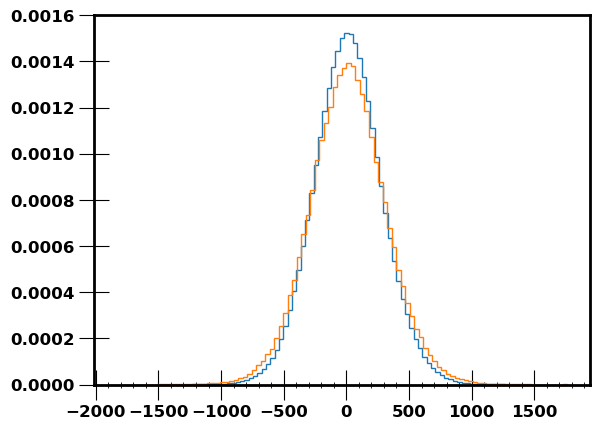

In [70]:
plt.hist(vpec.ravel(), bins=100, density=True, histtype="step")
_ = plt.hist(halos.vpec, bins=100, density=True, histtype="step")

In [71]:
halos["z_cosmo"] = dc_to_z(halos.d_c)

In [72]:
halos["z"] = (1 + halos.z_cosmo) * (1 + halos.vpec / c * 1e3) - 1

In [73]:
from astropy.coordinates import SkyCoord
from astropy.units import Mpc

coords = SkyCoord(
    x=halos.pos_x,
    y=halos.pos_y,
    z=halos.pos_z,
    representation_type="cartesian",
    unit=Mpc,
)

In [94]:
halos["ra"] = coords.icrs.spherical.lon.value
# halos.ra -= (halos.ra > 180) * 360
halos["dec"] = coords.icrs.spherical.lat.value

In [95]:
halos.to_csv("data/2M++_subhalo_1.csv")

##### Some plots

In [ ]:
halos = pandas.read_csv("data/2M++_subhalo_0.csv")
halos_ = pandas.read_csv("data/2M++_subhalo_1.csv")

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection="3d"))
ax.scatter(halos.pos_x, halos.pos_y, halos.pos_z, s=2, marker=".", alpha=0.1)
ax.scatter(halos_.pos_x, halos_.pos_y, halos_.pos_z, s=2, marker=".", alpha=0.1)

In [ ]:
one_axis = np.linspace(0, 1000, 256, endpoint=False)
y, x, z = np.meshgrid(one_axis, one_axis, one_axis)
centroids = np.c_[x.ravel(),y.ravel(),z.ravel()] + 1000/512

In [ ]:
from scipy.spatial import cKDTree
tree = cKDTree(centroids, boxsize=1000)

In [ ]:
dist, id = tree.query(np.c_[halos.pos_x, halos.pos_y, halos.pos_z] + 500)
dist_, id_ = tree.query(np.c_[halos_.pos_x, halos_.pos_y, halos_.pos_z] + 500)

In [ ]:
positions = (centroids - 500)

In [ ]:
with h5py.File("./data/velocity_cic_0.hdf5", "r") as file:
    vpec = np.array(file["velocity_field_radial"])
    v_x = np.array(file["velocity_field_0"])
    v_y = np.array(file["velocity_field_1"])
    v_z = np.array(file["velocity_field_2"])
v = np.concatenate(
    [
        v_x.reshape(256, 256, 256, 1),
        v_y.reshape(256, 256, 256, 1),
        v_z.reshape(256, 256, 256, 1),
    ],
    axis=3,
)
with h5py.File("./data/velocity_cic_1.hdf5", "r") as file:
    vpec_ = np.array(file["velocity_field_radial"])
    v_x = np.array(file["velocity_field_0"])
    v_y = np.array(file["velocity_field_1"])
    v_z = np.array(file["velocity_field_2"])
v_ = np.concatenate(
    [
        v_x.reshape(256, 256, 256, 1),
        v_y.reshape(256, 256, 256, 1),
        v_z.reshape(256, 256, 256, 1),
    ],
    axis=3,
)

In [ ]:
my_vpec = np.sum(positions[id]*v.reshape(-1, 3)[id], axis=1)/np.sqrt(np.sum(positions[id]**2, axis=1))
my_vpec_ = np.sum(positions[id_]*v_.reshape(-1, 3)[id_], axis=1)/np.sqrt(np.sum(positions[id_]**2, axis=1))

In [ ]:
calc_vpec=np.sum(np.multiply(v.reshape(-1, 3)[id], positions[id]), axis=1)/np.linalg.norm(positions[id], ord=2, axis=1)
calc_vpec_=np.sum(np.multiply(v_.reshape(-1, 3)[id_], positions[id_]), axis=1)/np.linalg.norm(positions[id_], ord=2, axis=1)

In [ ]:
halos['calc_vpec'] = calc_vpec
halos_['calc_vpec'] = calc_vpec_

In [ ]:
halos.columns

In [ ]:
fig = corner_(halos, var_names=["pos_x", "pos_y", "pos_z", "vx", "vy", "vz", "vpec", "calc_vpec"], return_fig=True)
corner_(halos_, var_names=["pos_x", "pos_y", "pos_z", "vx", "vy", "vz", "vpec", "calc_vpec"], fig=fig, color='r')
plt.tight_layout()

In [ ]:
plt.hist(vpec.ravel(), bins=100, density=True, histtype="step", label=r"$VP_{grid}$")
_ = plt.hist(calc_vpec, bins=100, density=True, histtype="step", label=r"$VP_{calc}$")
_ = plt.hist(halos.vpec, bins=100, density=True, histtype="step", label=r"$VP_{halos}$")
plt.legend()


In [ ]:
plt.hist(vpec_.ravel(), bins=100, density=True, histtype="step", label=r"$VP_{grid}$")
_ = plt.hist(calc_vpec_, bins=100, density=True, histtype="step", label=r"$VP_{calc}$")
_ = plt.hist(halos_.vpec, bins=100, density=True, histtype="step", label=r"$VP_{halos}$")
plt.legend()


In [ ]:
_ = plt.hist(calc_vpec - halos.vpec, bins=100, density=True, histtype="step", label=r"$VP_{calc} - VP_{halos}$")

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection="3d"))
ax.scatter(*positions[id].T, s=2, marker=".", alpha=0.1)
ax.scatter(halos.pos_x, halos.pos_y, halos.pos_z, s=2, marker=".", alpha=0.1)

In [ ]:
_=plt.hist(vpec.ravel()[id_] - halos_.vpec, bins=100)
mean, std = (vpec.ravel()[id_] - halos_.vpec).mean(), (vpec.ravel()[id_] - halos_.vpec).std()
plt.axvline(mean, color="r", label=rf'Mean ${mean:.3g}$')
plt.axvline(mean + std, color="r", linestyle=':', label=rf'std ${std:.3g}$')
plt.axvline(mean - std, color="r", linestyle=':')
plt.xlabel(r"$vp_{grid} - vp_{halo}$")
plt.legend()

In [ ]:
plt.scatter(halos.z_cosmo, halos.z, marker=".", s=0.1, alpha=0.1)
plt.scatter(halos_.z_cosmo, halos_.z, marker=".", s=0.1, alpha=0.1)

In [ ]:
z_max = 0.11
n_bins = 10
width = z_max / n_bins
bounds = np.linspace(0, z_max - width, n_bins)

in_bins = [(halos.z > d_min) & (halos.z < d_min + width) for d_min in bounds]
in_bins_ = [(halos_.z > d_min) & (halos_.z < d_min + width) for d_min in bounds]
plt.scatter(
    halos.z[halos.z < z_max],
    halos.vpec[halos.z < z_max],
    marker=".",
    alpha=0.01,
    label="Grid 0",
)

plt.scatter(
    halos_.z[halos_.z < z_max],
    halos_.vpec[halos_.z < z_max],
    marker=".",
    color="tab:red",
    alpha=0.01,
    label="Grid 1",
)

plt.errorbar(
    bounds + width / 2,
    [halos.vpec[filt].mean() for filt in in_bins],
    yerr=[halos.vpec[filt].std() for filt in in_bins],
    xerr=width / 2,
    linestyle="",
    color="blue",
    linewidth=2,
    alpha=1,
    capsize=2,
)

plt.errorbar(
    bounds + width / 2,
    [halos_.vpec[filt].mean() for filt in in_bins_],
    yerr=[halos_.vpec[filt].std() for filt in in_bins_],
    xerr=width / 2,
    linestyle="",
    color="red",
    linewidth=2,
    alpha=1,
    capsize=2,
)

plt.axhline(0, color="k", linestyle=":")
plt.legend()
plt.xlabel(r'$z$')
plt.ylabel(r'vpec')


In [ ]:
fig, ax = plt.subplots(figsize=(20, 7), subplot_kw=dict(projection="mollweide"))
ax.scatter(
    halos.ra[halos.z_cosmo < 0.1] * np.pi / 180,
    halos.dec[halos.z_cosmo < 0.1] * np.pi / 180,
    marker=".",
    s=2,
    alpha=0.2,
)
ax.scatter(
    halos_.ra[halos_.z_cosmo < 0.1] * np.pi / 180,
    halos_.dec[halos_.z_cosmo < 0.1] * np.pi / 180,
    marker=".",
    s=2,
    alpha=0.2,
)

## True ZTF

In [8]:
clusters = pandas.read_csv('./data/clusters.csv', index_col=0)
halos=pandas.read_csv('./data/reduced_hbt/halos_highres_5.csv')

In [9]:
import ztfcosmo
ztf = ztfcosmo.get_data(# good_coverage=True,
                        # good_lcfit=True,
                        )
ztf.columns

Index(['redshift', 'redshift_err', 'source', 't0', 'x0', 'x1', 'c', 't0_err',
       'x0_err', 'x1_err', 'c_err', 'cov_t0_x0', 'cov_t0_x1', 'cov_t0_c',
       'cov_x0_x1', 'cov_x0_c', 'cov_x1_c', 'mwebv', 'mwr_v', 'mwebv_err',
       'fitprob', 'ra', 'dec', 'sn_type', 'sub_type', 'lccoverage_flag',
       'fitquality_flag', 'iau_name', 'frac_fitted', 'ra_host', 'dec_host',
       'globalmass', 'globalmass_err', 'globalrestframe_gz',
       'globalrestframe_gz_err', 'd_dlr', 'localmass', 'localmass_err',
       'localrestframe_gz', 'localrestframe_gz_err'],
      dtype='object')

Text(0.5, 0, '$z$')

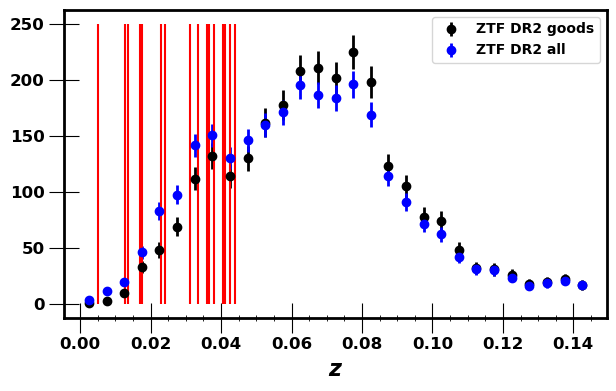

In [10]:
ztf_bins = np.arange(0, 0.15, 0.005)
ztf_cent_bins = (ztf_bins[:-1] + ztf_bins[1:])/2
ztf_count_all,_ = np.histogram(ztf.redshift, ztf_bins)
ztf_goods = ztf[(ztf.lccoverage_flag==1.0) & (ztf.fitquality_flag == 1.0)]
ztf_count,_ = np.histogram(ztf_goods.redshift, ztf_bins)

plt.figure(figsize=(7, 4))
def plot_ztf(ztf_cent_bins, ztf_count, norm=1, **kwargs):
    default_kwargs=dict(marker='o', color='k', elinewidth=2, linestyle='', label='ZTF DR2')
    default_kwargs.update(**kwargs)
    plt.gca().errorbar(ztf_cent_bins, ztf_count*norm, yerr=np.sqrt(ztf_count)*norm, **default_kwargs)

plot_ztf(ztf_cent_bins, ztf_count, label='ZTF DR2 goods')
plot_ztf(ztf_cent_bins, ztf_count_all, norm = ztf_count.sum()/ztf_count_all.sum(), label='ZTF DR2 all', color='b')

plt.vlines(clusters.z, ymin=0, ymax=250, color='r')

plt.legend()
plt.xlabel("$z$")

In [11]:
host_z = pandas.read_csv('./data/ztfdr2_galcat_redshifts.csv')
# host_z = host_z[host_z.ztfname.isin(ztf.index)]
host_z.columns

Index(['ztfname', 'z', 'z_err', 'z_source'], dtype='object')

In [12]:
print(ztf[~ztf.index.isin(host_z.ztfname)].groupby("source").count().redshift)
print(host_z.groupby('z_source').count().z)

source
z_SEDm         121
z_gal           12
z_nonSEDm      199
z_override       8
z_snid        1077
z_unknown       12
Name: redshift, dtype: int64
z_source
desi              52
mosthost        1570
ned                7
ned_2df            1
ned_sdss           3
ned_uzc            1
sdss             253
simbad            61
simbad_2df         4
simbad_2mass      57
simbad_6df       131
simbad_cf         11
simbad_gama        3
simbad_uzc        45
Name: z, dtype: int64


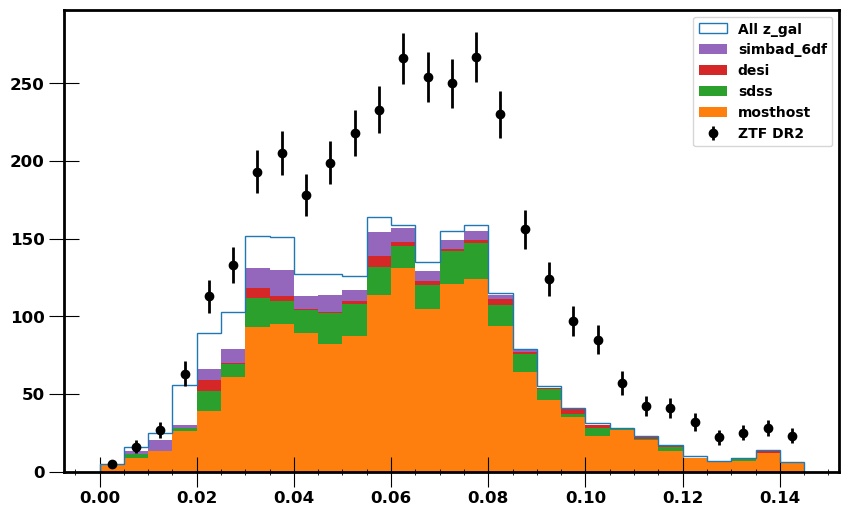

In [13]:
plt.figure(figsize=(10, 6))
host_count,_,_=plt.hist(host_z.z,
         bins=ztf_bins,
         histtype='step',
         label="All z_gal")

plt.errorbar(ztf_cent_bins, ztf_count_all, yerr=np.sqrt(ztf_count_all), marker='o', color='k', elinewidth=2, linestyle='', label='ZTF DR2')
sources = ["mosthost", "sdss", "desi",
           "simbad_6df"]
plt.hist([host_z[host_z.z_source == source].z for source in sources],
         bins=ztf_bins,
         stacked=True,
         histtype='stepfilled',
         label=sources)
plt.legend()
# plt.yscale('log')


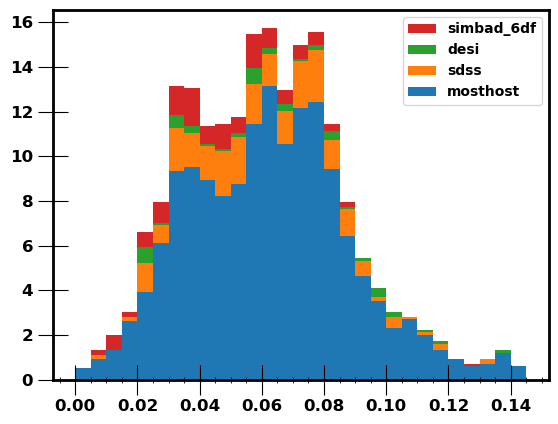

In [14]:
plt.hist([host_z[host_z.z_source == source].z for source in sources],
         bins=ztf_bins,
         stacked=True,
         histtype='stepfilled',
         label=sources,
         density=True,)
plt.legend()

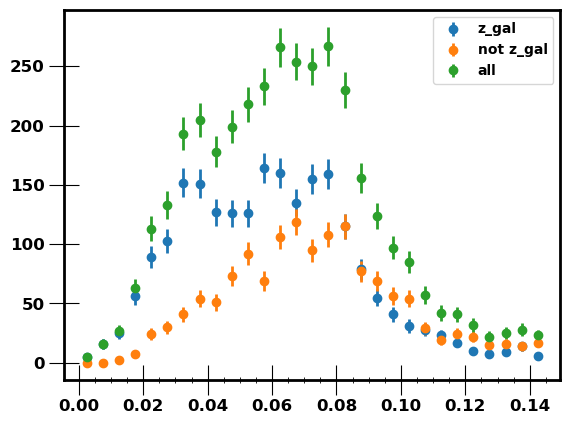

In [15]:
ztf_zsn = ztf[~ztf.index.isin(host_z.ztfname)]
ztf_zsn_count,_ = np.histogram(ztf_zsn.redshift, ztf_bins)

ztf_zhost = ztf[ztf.index.isin(host_z.ztfname)]
ztf_zhost_count,_ = np.histogram(ztf_zhost.redshift, ztf_bins)

plt.errorbar(ztf_cent_bins, ztf_zhost_count, np.sqrt(ztf_zhost_count), linestyle='', marker='o', elinewidth=2, label='z_gal')
plt.errorbar(ztf_cent_bins, ztf_zsn_count, np.sqrt(ztf_zsn_count), linestyle='', marker='o', elinewidth=2, label='not z_gal')
plt.errorbar(ztf_cent_bins, ztf_count_all, np.sqrt(ztf_count_all), linestyle='', marker='o', elinewidth=2, label='all')
plt.legend()

In [16]:
SDSS=pandas.read_csv('data/SDSS_500k_galaxy.csv', skiprows=1)

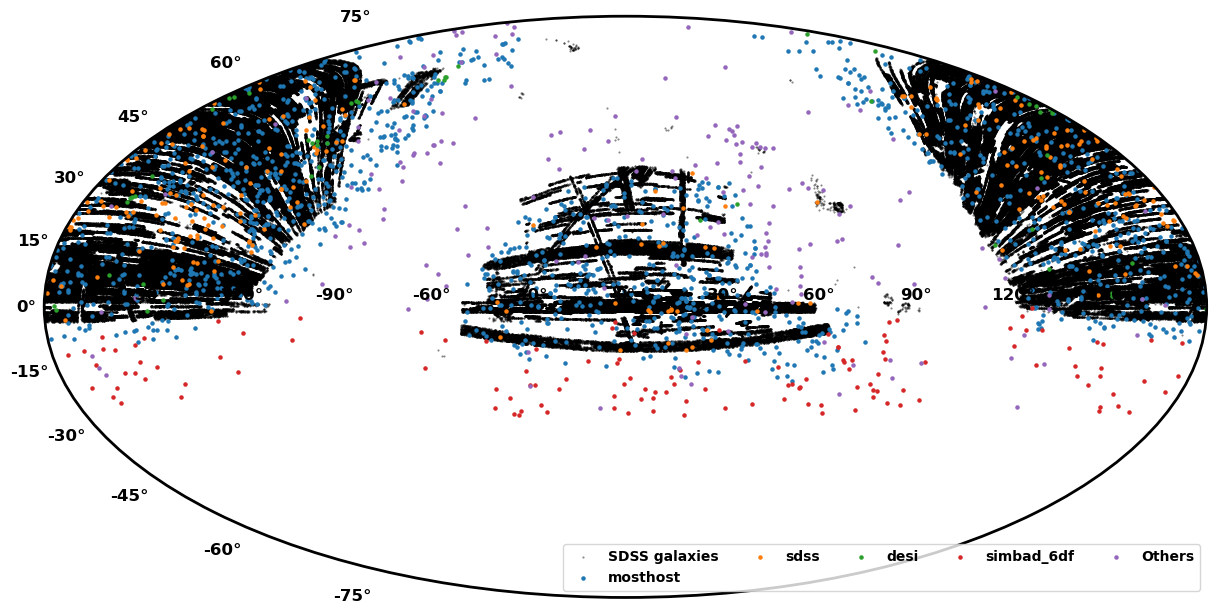

In [17]:
fig, ax = plt.subplots(figsize=(15, 8), subplot_kw=dict(projection='mollweide'))
scatter_mollweide(SDSS, ax=ax, marker='.', color='k', s=1, alpha=0.5, label="SDSS galaxies")

for source in sources:
    scatter_mollweide(ztf[ztf.index.isin(host_z.ztfname[host_z.z_source==source])], ax=ax, marker='o', s=5, alpha=1, label=source)
scatter_mollweide(ztf[ztf.index.isin(host_z.ztfname[~host_z.z_source.isin(sources)])], ax=ax, marker='o', s=5, alpha=1, label="Others")


plt.legend(loc='lower right', ncols=5)

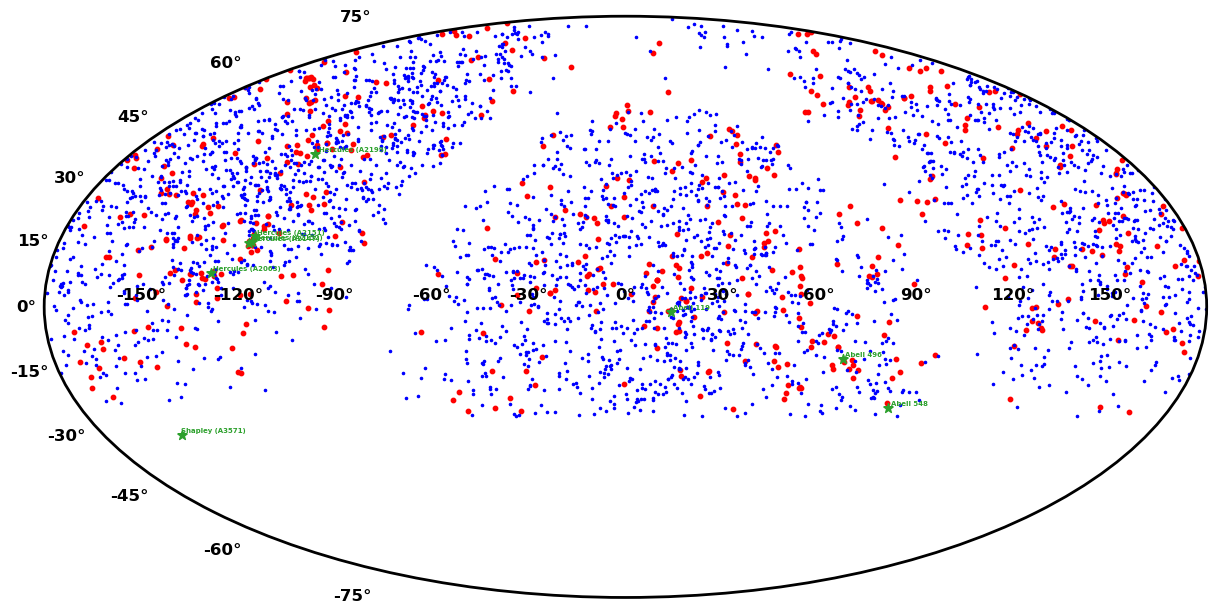

In [18]:
fig, ax = plt.subplots(figsize=(15, 8), subplot_kw=dict(projection='mollweide'))
scatter_mollweide(ztf[ztf.redshift.between(0.03, 0.045)], ax=ax, marker='o', color='r', s=10, alpha=1, label="bump")
scatter_mollweide(ztf[~ztf.redshift.between(0.03, 0.045)], ax=ax, marker='.', color='b', s=10, alpha=1, label="others")
scatter_mollweide(clusters[clusters.z.between(0.03, 0.045)], ax=ax, marker='*', color='tab:green', s=50, alpha=1)
for name, ra, dec in clusters[clusters.z.between(0.03, 0.045)][["name", "ra", "dec"]].values:
    ax.text(ra*np.pi/180 - 2*np.pi*(ra > 180) +0.01, dec*np.pi/180 +0.01, name, fontsize=5, color='tab:green')

In [19]:
clusters[clusters.z.between(0.03, 0.04) & clusters.ra.between(230, 260)]

name      SGx       SGy       SGz          ra        dec  \
10  Hercules (A2199)  26.3204   82.7682  104.2647  247.158359  39.548590   
11  Hercules (A2147) -37.1809  102.8894  123.8503  240.577907  16.019998   
12  Hercules (A2063) -57.4741  109.7154   96.2186  230.757746   8.639413   
14  Hercules (A2151)      NaN       NaN       NaN  241.717900  17.781000   

           d_c         z  
10  135.699912  0.031048  
11  165.249946  0.037869  
12  156.839919  0.035926  
14         NaN  0.036600

In [20]:
clusters

name       SGx       SGy       SGz          ra        dec  \
0       Virgo Cluster   -4.8700   21.2979   -0.8960  187.705194  12.391630   
1   Centaurus (A3526)  -50.6848   22.0594  -11.1859  192.208579 -41.342682   
2       Hydra (A1060)  -35.8866   30.7912  -36.3620  159.178136 -27.531184   
3      Perseus (A426)   72.5443  -15.5785  -18.8577   49.955986  41.510707   
4        Coma (A1656)    0.6561  104.4230   15.4200  195.039823  27.974968   
5       Norma (A3627)  -72.9389  -10.5106    8.9307  243.797288 -61.046318   
6         Leo (A1367)   -3.5077   98.9637  -18.3534  176.067591  19.997654   
7           Abell 119   81.8756 -172.6919   -2.1330   14.076222  -1.216657   
8           Abell 496   35.7520  -73.7681 -120.3062   68.410027 -13.259183   
9           Abell 548   -8.5434  -58.7090 -175.2079   86.757348 -25.616283   
10   Hercules (A2199)   26.3204   82.7682  104.2647  247.158359  39.548590   
11   Hercules (A2147)  -37.1809  102.8894  123.8503  240.577907  16.019998   
12   Hercules (A2063)  -57.4741  109.7154   96.2186  230.757746   8.639413   
13   Hercules (A2152)       NaN       NaN       NaN  241.384200  16.442000   
14   Hercules (A2151)       NaN       NaN       NaN  241.717900  17.781000   
13    Shapley (A3571) -154.9777   84.1743    6.4640  206.868318 -32.849735   

           d_c         z  
0    21.865961  0.004973  
1    56.397610  0.012849  
2    59.650156  0.013592  
3    76.557024  0.017461  
4   105.557424  0.024112  
5    74.231484  0.016928  
6   100.712289  0.022999  
7   191.129945  0.043862  
8   145.579943  0.033326  
9   184.979849  0.042436  
10  135.699912  0.031048  
11  165.249946  0.037869  
12  156.839919  0.035926  
13         NaN  0.041000  
14         NaN  0.036600  
13  176.479981  0.040468

(5.0, 45.0)

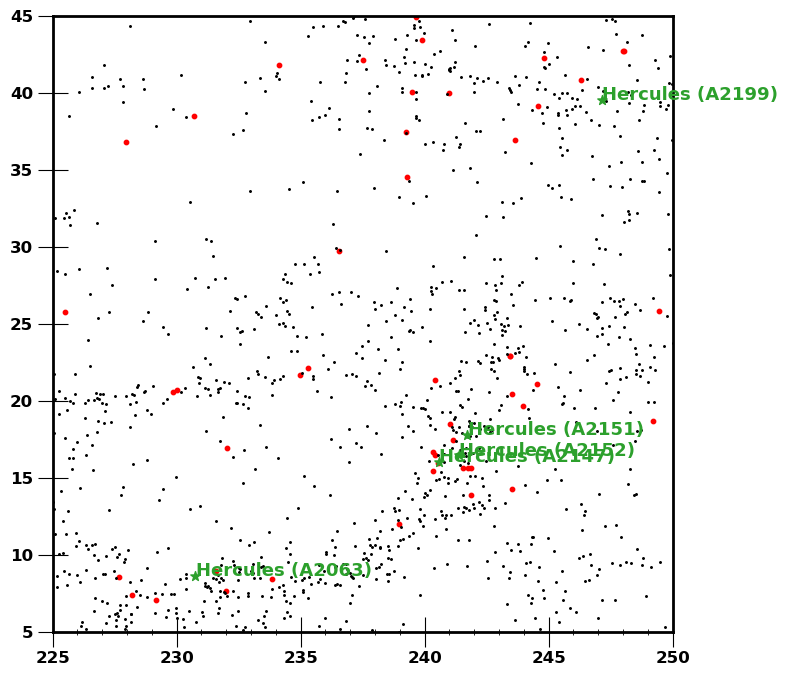

In [21]:
fig, ax = plt.subplots(figsize=(8, 8))
ztf_filt = ztf.redshift.between(0.03, 0.045) & ztf.ra.between(225, 250) & ztf.dec.between(5, 45)
ax.scatter(ztf[ztf_filt].ra, ztf[ztf_filt].dec, marker='o', color='r', s=10, alpha=1, label="bump")
# ax.scatter(ztf[~ztf_filt].ra, ztf[~ztf_filt].dec, marker='.', color='b', s=10, alpha=1, label="others")

ax.scatter(halos[halos.z.between(0.03, 0.045) & halos.ra.between(225, 250) & halos.dec.between(5, 45)].ra,
           halos[halos.z.between(0.03, 0.045) & halos.ra.between(225, 250) & halos.dec.between(5, 45)].dec,
           marker='.', color='k', s=5, alpha=1, label="SDSS galaxies")

ax.scatter(clusters[clusters.z.between(0.03, 0.045) & clusters.ra.between(210, 260)].ra,
           clusters[clusters.z.between(0.03, 0.045) & clusters.ra.between(210, 260)].dec,
           marker='*', color='tab:green', s=50, alpha=1)
for name, ra, dec in clusters[clusters.z.between(0.03, 0.045) & clusters.ra.between(230, 260)][["name", "ra", "dec"]].values:
    ax.text(ra +0.01, dec+0.01, name, fontsize=13, color='tab:green')
ax.set_xlim(225, 250)
ax.set_ylim(5, 45)


In [22]:
near_clusters=[]
for name, ra, dec in clusters[clusters.z.between(0.03, 0.045)][["name", "ra", "dec"]].values:
    near_clusters.append(ztf[(ztf.redshift.between(0.03, 0.045) & ztf.ra.between(ra - 10, ra + 10) & ztf.dec.between(dec - 10, dec + 10))].index.values)
    print("Near", name, " : \n", near_clusters[-1])
near_clusters=np.hstack(near_clusters)
print("Total unique = ", len(np.unique(near_clusters)))

Near Abell 119  : 
 ['ZTF18abpdcuf' 'ZTF18abuhzfc' 'ZTF18abvejbm' 'ZTF18acbudzh'
 'ZTF18acbudzo' 'ZTF18acbxsge' 'ZTF18acmxkzj' 'ZTF18adaadmh'
 'ZTF19aaephty' 'ZTF19abdkdoz' 'ZTF19abheamc' 'ZTF19ablovot'
 'ZTF19ablqnuw' 'ZTF19acbacvu' 'ZTF19acfthre' 'ZTF19acgldqr'
 'ZTF19achetvw' 'ZTF20aahidph' 'ZTF20aamujvi' 'ZTF20ablxtlp'
 'ZTF20absvtnc' 'ZTF20abyvtds' 'ZTF20acordqz' 'ZTF20acyhena']
Near Abell 496  : 
 ['ZTF18abvtcts' 'ZTF18actasgb' 'ZTF18acvbiff' 'ZTF18acxhvkv'
 'ZTF19aainjpz' 'ZTF19aainjqn' 'ZTF19aakpmoy' 'ZTF19abttrte'
 'ZTF19abttstb' 'ZTF19acbmddl' 'ZTF20aalbjpf' 'ZTF20aalbjqh'
 'ZTF20abydkrl' 'ZTF20acpmgdz']
Near Abell 548  : 
 ['ZTF18acrukkl' 'ZTF19acbmqpu' 'ZTF19acyfoha']
Near Hercules (A2199)  : 
 ['ZTF18aagstdc' 'ZTF18aagtcxj' 'ZTF18aaiykoz' 'ZTF18aamlhee'
 'ZTF18aaqvuhl' 'ZTF18aasprui' 'ZTF18aaxsioa' 'ZTF18abcrxoj'
 'ZTF18abltdfj' 'ZTF18abuqugw' 'ZTF19aaujzqh' 'ZTF19abitbcj'
 'ZTF19abqhikf' 'ZTF19abvalfd' 'ZTF19acaqyjp' 'ZTF19acekreh'
 'ZTF20aattsxa' 'ZTF20aavnnat' 'ZTF20acj

In [23]:
clusters[clusters.z.between(0.03, 0.045)][["name", "ra", "dec"]]

name          ra        dec
7          Abell 119   14.076222  -1.216657
8          Abell 496   68.410027 -13.259183
9          Abell 548   86.757348 -25.616283
10  Hercules (A2199)  247.158359  39.548590
11  Hercules (A2147)  240.577907  16.019998
12  Hercules (A2063)  230.757746   8.639413
13  Hercules (A2152)  241.384200  16.442000
14  Hercules (A2151)  241.717900  17.781000
13   Shapley (A3571)  206.868318 -32.849735

In [24]:
rdm_remove = []
n_ = 8
rdm_ra = np.random.uniform(0, 360, n_)
rdm_dec = 180/np.pi*np.arcsin(np.random.uniform(-0.13, 1, n_))
for ra, dec in zip(rdm_ra, rdm_dec):
    rdm_remove.append(ztf[(ztf.redshift.between(0.03, 0.04) & ztf.ra.between(ra - 10, ra + 10) & ztf.dec.between(dec - 10, dec + 10))].index.values)
    print(ra, dec, rdm_remove[-1])
rdm_remove = np.hstack(rdm_remove)
print('Total :', len(np.unique(rdm_remove)))

306.9660136288117 7.480859068623271 ['ZTF19abiahik']
320.959054232295 18.43310066404621 ['ZTF18absnqyo' 'ZTF18acdwohd' 'ZTF20acpjfln']
287.9158336703211 69.94721575060173 ['ZTF18aaupmks' 'ZTF18abfhryc' 'ZTF20acbakkg']
352.7263345207194 21.366030997448988 ['ZTF18acehilk' 'ZTF19abdyyut' 'ZTF19abmolyr' 'ZTF19acykjcw'
 'ZTF20aalkfei' 'ZTF20abgbwmt' 'ZTF20abtctgr' 'ZTF20abzbfct']
106.59084811020672 47.86054017733882 ['ZTF18abtzzka' 'ZTF18abykswp' 'ZTF18acmzpbf' 'ZTF18adbhvze'
 'ZTF19aaklnni' 'ZTF19acojuzv' 'ZTF20aaffgwg' 'ZTF20aatvzmm'
 'ZTF20acurtpj']
53.830844647751434 6.235618154113551 ['ZTF18abwkczr' 'ZTF18acmyihj' 'ZTF18acslknd' 'ZTF19abkgbul'
 'ZTF19abrogbl' 'ZTF19abywqza' 'ZTF19acgogcm' 'ZTF19acyltbi'
 'ZTF20aaesewy' 'ZTF20aaivjce' 'ZTF20abqfgee']
13.757249894809402 10.697691142903583 ['ZTF18abpdcuf' 'ZTF18acmxkzj' 'ZTF18acmxmlq' 'ZTF18acrcetn'
 'ZTF19aaephty' 'ZTF19acvieqw' 'ZTF20ablxtlp' 'ZTF20absvtnc'
 'ZTF20abucvpo' 'ZTF20acyhena']
25.27939757715462 2.6959753720002584 ['ZTF18abpd

In [35]:
from dustmaps.planck import PlanckQuery
from astropy.coordinates import SkyCoord
nside=128
ra, dec = healpy.pix2ang(nside, np.arange(healpy.nside2npix(nside)), lonlat=True)
dusts = PlanckQuery()(SkyCoord(ra, dec, unit="deg"))
smoothed_dusts = healpy.smoothing(dusts, 0.1)

2025-05-15 11:06:47 INFO healpy - Sigma is 145.987664 arcmin (0.042466 rad) 
2025-05-15 11:06:47 INFO healpy - -> fwhm is 343.774677 arcmin
2025-05-15 11:06:47 INFO healpy - Sigma is 0.000000 arcmin (0.000000 rad) 
2025-05-15 11:06:47 INFO healpy - -> fwhm is 0.000000 arcmin


In [110]:
nside=128
map_dm = np.zeros(healpy.nside2npix(nside=nside))
map_vpec = np.zeros(healpy.nside2npix(nside=nside))
count = np.zeros(healpy.nside2npix(nside=nside))

count_vpec = []
vpecs = []
vpec_bins=np.linspace(0, 0.1, 30)

for nb in tqdm(range(50)):
    halos=pandas.read_csv(f'./data/reduced_hbt/halos_highres_{nb}.csv')
    filt_dm = halos.z.between(0.03, 0.04)
    index_dm = healpy.ang2pix(nside, halos[filt_dm].ra, halos[filt_dm].dec, lonlat=True)
    for id in index_dm.values:
        map_dm[id] += halos.loc[id, 'BoundM200Crit']
        map_vpec[id] += halos.loc[id, 'vpec']
        count[id] += 1
    
    idx = halos.z.values.argsort()
    to_bin = halos.z.values[idx]
    data = halos.vpec.values[idx]
    bounds =np.concatenate((
        to_bin.searchsorted(vpec_bins[:-1], 'left'),
        to_bin.searchsorted(vpec_bins[-1:], 'right')))
    count_vpec.append(np.diff(bounds))
    vpecs.append(np.array([data[bounds[k]:bounds[k+1]].sum() for k in range(len(bounds)-1)]))
map_vpec[count != 0] /= count[count!=0]

  0%|          | 0/50 [00:00<?, ?it/s]

In [111]:
map_dm/=50
vpecs = np.vstack(vpecs)
count_vpec = np.vstack(count_vpec)

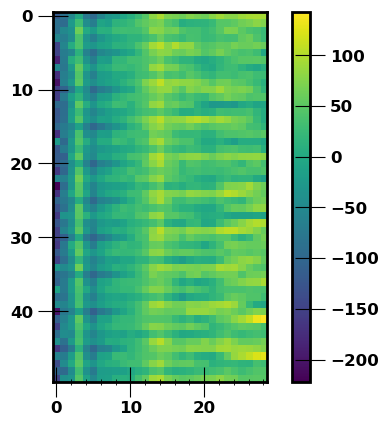

In [112]:
plt.imshow(vpecs/count_vpec)
plt.colorbar()

Text(0.5, 0, '$z$')

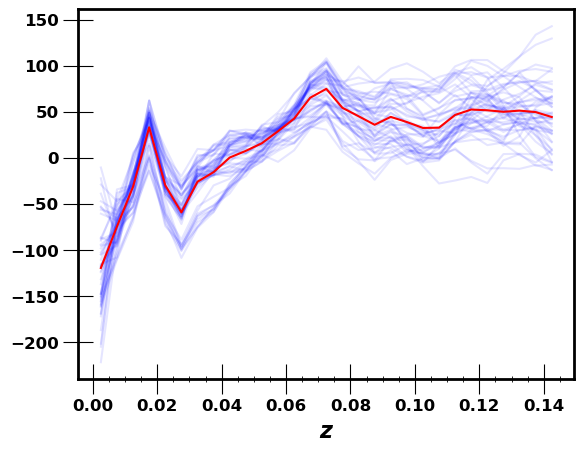

In [116]:
plt.plot(ztf_cent_bins, (vpecs/count_vpec).T, alpha=0.1, color='b', label='Mocks')
plt.plot(ztf_cent_bins, (vpecs/count_vpec).mean(axis=0), color='r', label='Mean')
plt.xlabel(r"$z$")

In [36]:
map_dm_ = np.copy(map_dm)
map_dm_[healpy.pix2ang(nside, np.arange(healpy.nside2npix(nside)), lonlat=True)[1] < -30] = 0.
map_dm_[smoothed_dusts > 0.3] = 0.
smoothed_dm = healpy.smoothing(map_dm_, 0.2)

map_vpec_ = np.copy(map_vpec)
map_vpec_[healpy.pix2ang(nside, np.arange(healpy.nside2npix(nside)), lonlat=True)[1] < -30] = 0.
map_vpec_[smoothed_dusts > 0.3] = 0.
smoothed_vpec = healpy.smoothing(map_vpec_, 0.2)


2025-05-15 11:06:48 INFO healpy - Sigma is 291.975328 arcmin (0.084932 rad) 
2025-05-15 11:06:48 INFO healpy - -> fwhm is 687.549354 arcmin
2025-05-15 11:06:48 INFO healpy - Sigma is 0.000000 arcmin (0.000000 rad) 
2025-05-15 11:06:48 INFO healpy - -> fwhm is 0.000000 arcmin
2025-05-15 11:06:48 INFO healpy - Sigma is 291.975328 arcmin (0.084932 rad) 
2025-05-15 11:06:48 INFO healpy - -> fwhm is 687.549354 arcmin
2025-05-15 11:06:48 INFO healpy - Sigma is 0.000000 arcmin (0.000000 rad) 
2025-05-15 11:06:48 INFO healpy - -> fwhm is 0.000000 arcmin


In [37]:
from astropy.units import degree, rad, Gpc
norm = 1/(cosmo.comoving_distance(0.04) - cosmo.comoving_distance(0.03))/(cosmo.angular_diameter_distance(0.035) * np.sqrt(healpy.nside2pixarea(nside, degrees=False)))**2

In [38]:
nside=128
map_ = np.zeros(healpy.nside2npix(nside=nside))
index = healpy.ang2pix(nside, ztf[ztf.redshift.between(0.03, 0.04)].ra, ztf[ztf.redshift.between(0.03, 0.04)].dec, lonlat=True)

for id in index.values:
    map_[id] += 1

low_smoothed_map = healpy.smoothing(map_, 0.07)
high_smoothed_map = healpy.smoothing(map_, 0.3)

2025-05-15 11:06:49 INFO healpy - Sigma is 102.191365 arcmin (0.029726 rad) 
2025-05-15 11:06:49 INFO healpy - -> fwhm is 240.642274 arcmin
2025-05-15 11:06:49 INFO healpy - Sigma is 0.000000 arcmin (0.000000 rad) 
2025-05-15 11:06:49 INFO healpy - -> fwhm is 0.000000 arcmin
2025-05-15 11:06:49 INFO healpy - Sigma is 437.962991 arcmin (0.127398 rad) 
2025-05-15 11:06:49 INFO healpy - -> fwhm is 1031.324031 arcmin
2025-05-15 11:06:49 INFO healpy - Sigma is 0.000000 arcmin (0.000000 rad) 
2025-05-15 11:06:49 INFO healpy - -> fwhm is 0.000000 arcmin


In [119]:
def add_clusters(clusters, ax=None, color="tab:red"):
    if ax==None:
        ax=plt.gca()    
    scatter_mollweide(clusters, ax=ax, marker='*', color=color, s=50, alpha=1)
    for name, ra, dec in clusters[["name", "ra", "dec"]].values:
        ax.text(ra*np.pi/180 - 2*np.pi*(ra > 180) +0.03, dec*np.pi/180 +0.03, name, fontsize=7, color=color)

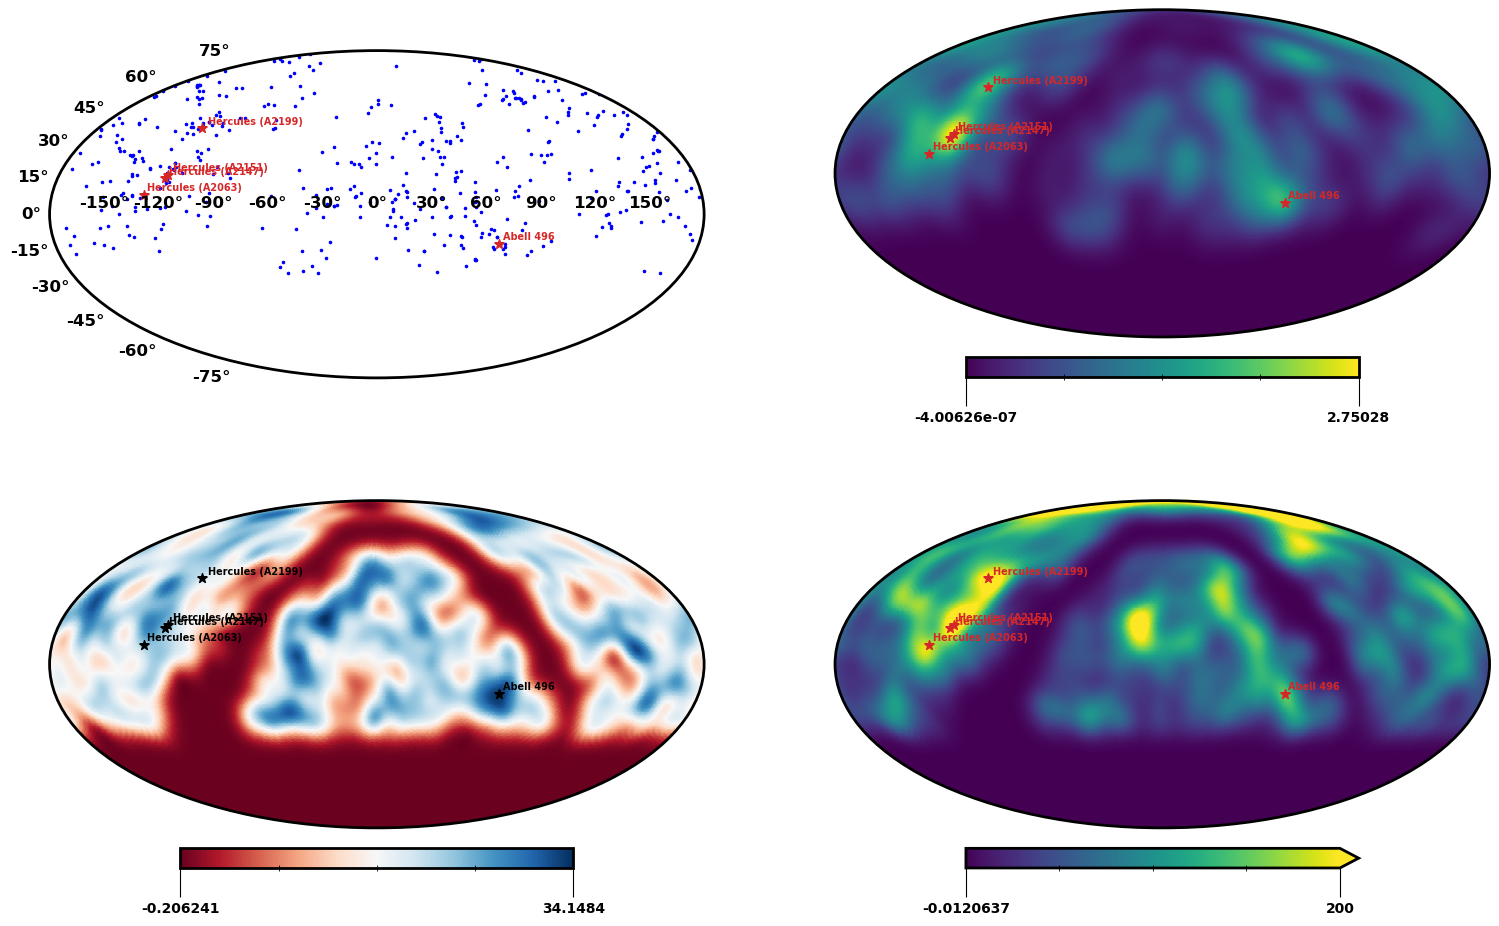

In [123]:
fig, axs = plt.subplots(figsize=(15, 10), nrows=2, ncols=2, subplot_kw=dict(projection="mollweide"))
scatter_mollweide(ztf[ztf.redshift.between(0.03, 0.042)], ax=fig.axes[0], marker='.', color='blue', s=10, alpha=1, label="bump")
healpy.projview(high_smoothed_map*norm.value/3/2.35*10**5, projection_type="mollweide", fig=fig, sub=222, flip='geo')
healpy.projview(smoothed_vpec, projection_type="mollweide", fig=fig, sub=223, cmap='RdBu', flip='geo')
healpy.projview(smoothed_dm, projection_type="mollweide", max=200, fig=fig, sub=224, flip='geo')

for ax, c in zip(fig.axes[0:4], ['tab:red', 'tab:red', 'k', 'tab:red']):
    add_clusters(clusters[clusters.z.between(0.03, 0.04)], ax, color=c)
plt.savefig('../../Hercules_vpec_dm_SN_SNd.png')

In [124]:
densities=smoothed_dm[healpy.ang2pix(nside, clusters[clusters.z.between(0.03,0.04)].ra, clusters[clusters.z.between(0.03,0.04)].dec, lonlat=True,)]

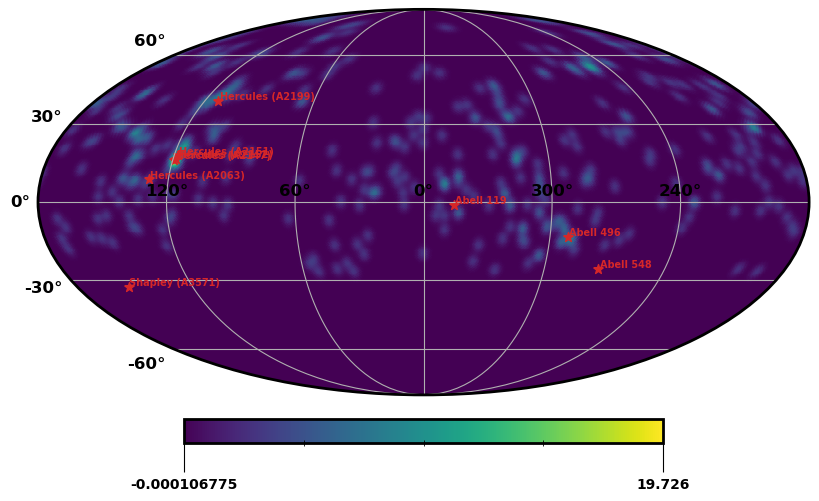

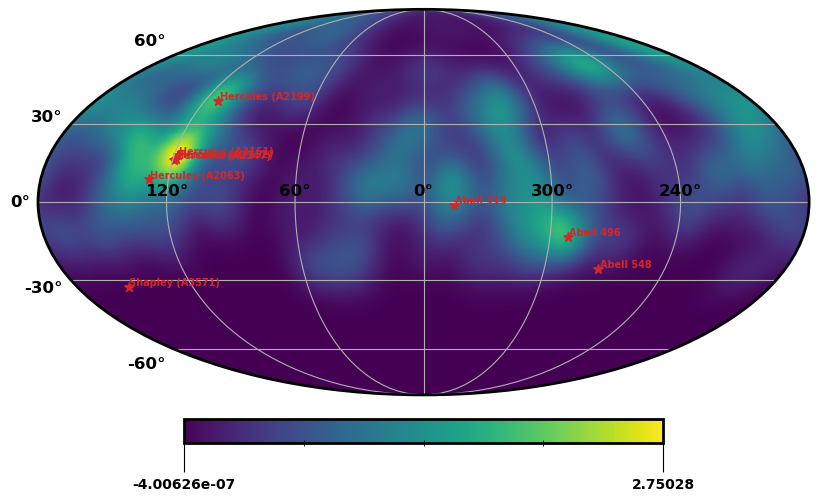

In [125]:
healpy.projview(low_smoothed_map*norm.value/3/2.35*10**5, graticule=True, graticule_labels =True, flip='geo')
scatter_mollweide(clusters[clusters.z.between(0.03, 0.045)], ax=plt.gca(), marker='*', color='tab:red', s=50, alpha=1)
for name, ra, dec in clusters[clusters.z.between(0.03, 0.045)][["name", "ra", "dec"]].values:
    plt.gca().text(ra*np.pi/180 - 2*np.pi*(ra > 180) +0.01, dec*np.pi/180 +0.01, name, fontsize=7, color='tab:red')

healpy.projview(high_smoothed_map*norm.value/3/2.35*10**5, graticule=True, graticule_labels =True, flip='geo')
scatter_mollweide(clusters[clusters.z.between(0.03, 0.045)], ax=plt.gca(), marker='*', color='tab:red', s=50, alpha=1)
for name, ra, dec in clusters[clusters.z.between(0.03, 0.045)][["name", "ra", "dec"]].values:
    plt.gca().text(ra*np.pi/180 - 2*np.pi*(ra > 180) +0.01, dec*np.pi/180 +0.01, name, fontsize=7, color='tab:red')


In [ ]:
healpy.nside2pixarea(nside, degrees=True)

0.2098234113027917

(array([  5.,  16.,  27.,  63., 113., 133., 173., 192., 178., 199., 218.,
        233., 266., 254., 250., 267., 230., 156., 124.,  97.,  85.,  57.,
         42.,  41.,  32.,  22.,  25.,  28.,  23.]),
 array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
        0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085,
        0.09 , 0.095, 0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 ,
        0.135, 0.14 , 0.145]),
 <BarContainer object of 29 artists>)

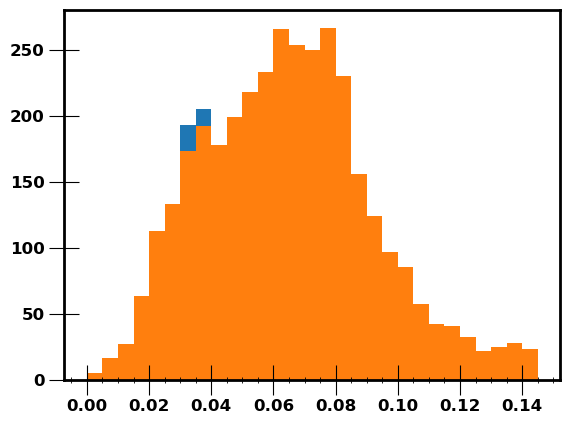

In [85]:
plt.hist(ztf.redshift, bins=ztf_bins, label='ZTF sample')
plt.hist(ztf[~ztf.index.isin(near_clusters)].redshift, bins=ztf_bins, label='ZTF without clusters')

Text(0, 0.5, '$N_{SN}$')

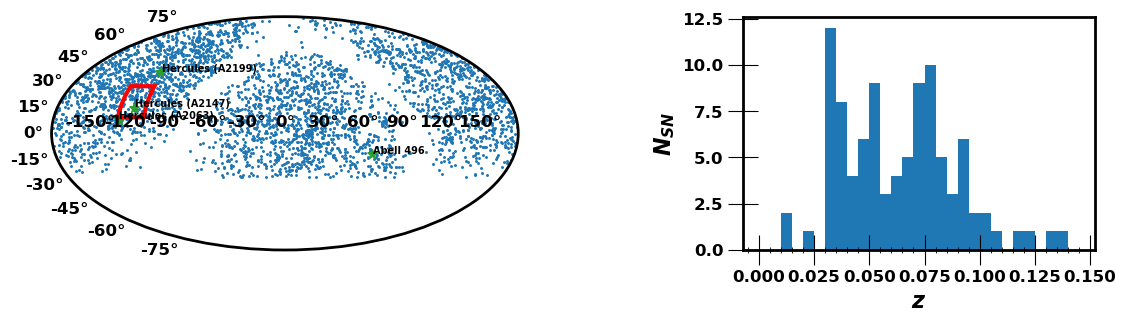

In [173]:
fig = plt.figure(figsize=(15, 10))
gs = plt.GridSpec(2, 2, width_ratios=[2, 1], height_ratios=[1, 2])

ax_moll = fig.add_subplot(gs[0], projection='mollweide')
ra_origin, dec_origin, ra_size, dec_size = (230, 10, 20, 20)

scatter_mollweide(ztf, ax=ax_moll, s=5, alpha=1)
scatter_mollweide(clusters[clusters.z.between(0.03, 0.04)], ax=ax_moll, marker='*', color='tab:green', s=50, alpha=1)
for name, ra, dec in clusters[clusters.z.between(0.03, 0.04)][["name", "ra", "dec"]].values:
    ax_moll.text(ra*np.pi/180 - 2*np.pi*(ra > 180) +0.01, dec*np.pi/180 +0.01, name, fontsize=7, color='k')
rect = plt.Rectangle((ra_origin*np.pi/180 - 2*np.pi*(ra_origin > 180), dec_origin*np.pi/180), ra_size*np.pi/180, dec_size*np.pi/180, edgecolor='r', fill=False, linewidth=3, alpha=1)
ax_moll.add_patch(rect)
ax_hist = fig.add_subplot(gs[1])

ax_hist.hist(ztf[ztf.ra.between(ra_origin, ra_origin+ra_size,) & ztf.dec.between(dec_origin, dec_origin+dec_size)].redshift, bins=ztf_bins)
ax_hist.set_xlabel(r"$z$")
ax_hist.set_ylabel(r"$N_{SN}$")

Text(0.5, 1.0, 'Others')

<Figure size 640x480 with 0 Axes>

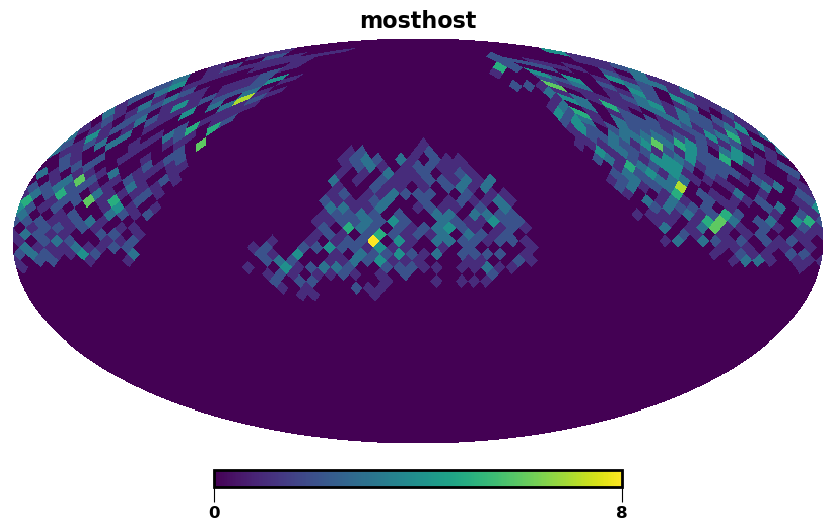

<Figure size 640x480 with 0 Axes>

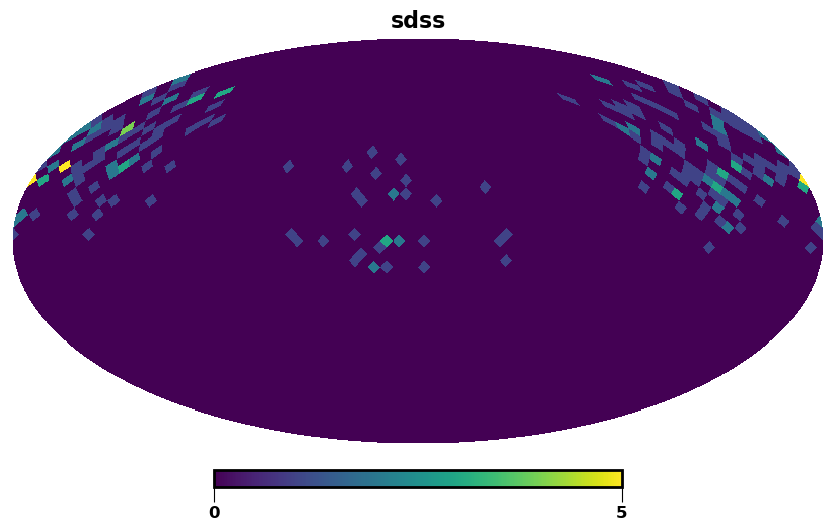

<Figure size 640x480 with 0 Axes>

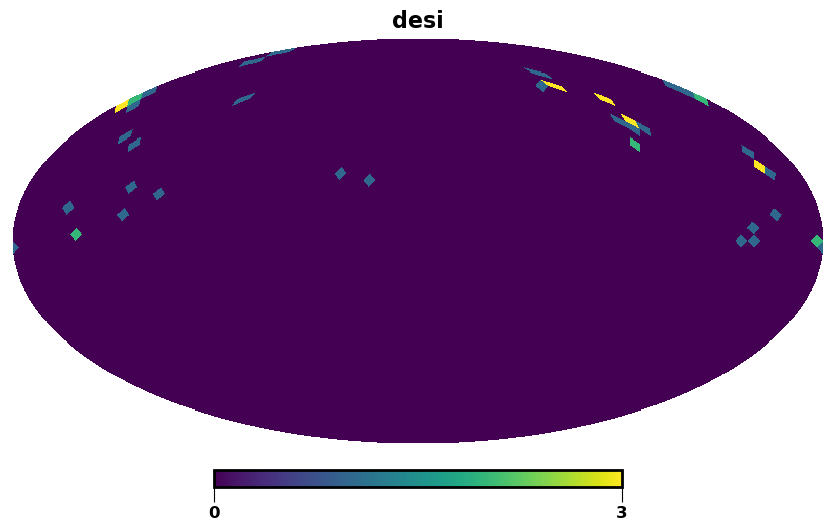

<Figure size 640x480 with 0 Axes>

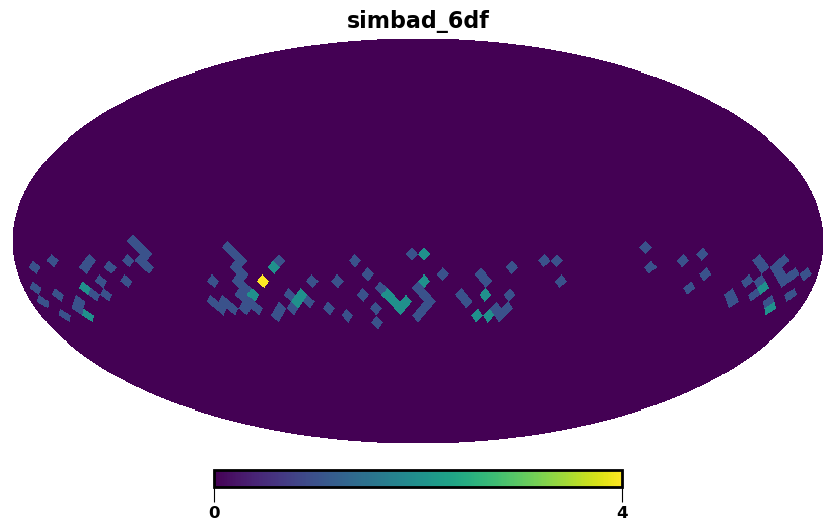

<Figure size 640x480 with 0 Axes>

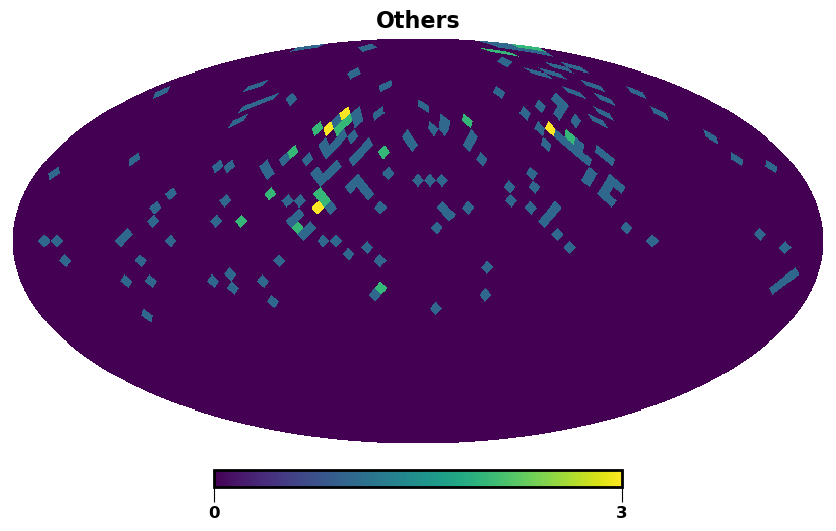

In [21]:
nside=16
for source in sources:
    plt.figure()
    sub_ztf = ztf[ztf.index.isin(host_z.ztfname[host_z.z_source==source])]
    healpy.mollview(np.bincount(healpy.ang2pix(nside, sub_ztf.ra, sub_ztf.dec, lonlat=True), minlength=healpy.nside2npix(nside)))    
    plt.title(source)

plt.figure()
sub_ztf = ztf[ztf.index.isin(host_z.ztfname[~host_z.z_source.isin(sources)])]
healpy.mollview(np.bincount(healpy.ang2pix(nside, sub_ztf.ra, sub_ztf.dec, lonlat=True), minlength=healpy.nside2npix(nside)))    
plt.title('Others')

In [22]:
SDSS_ = SDSS[np.abs(SDSS.redshift_err/SDSS.redshift) < 1e-1].copy()

In [23]:
halos=pandas.read_csv("data/2M++_subhalo_0.csv", index_col=0)

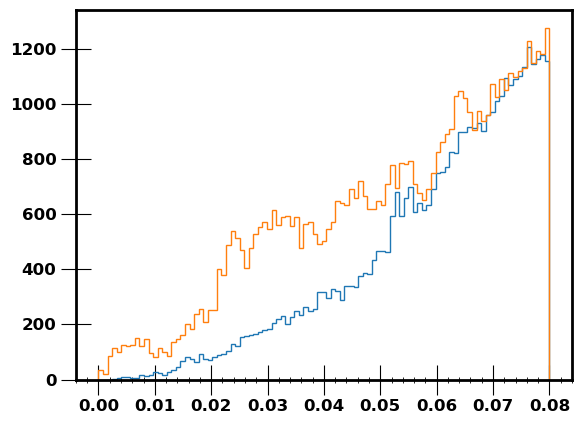

In [24]:
_=plt.hist(halos.z, bins=np.linspace(0, 0.08, 100), histtype='step')
_=plt.hist(SDSS_.redshift, bins=np.linspace(0, 0.08, 100), histtype='step')

In [25]:
vol_lim_ztf = ztf[ztf.redshift < 0.06]

In [26]:
def rand_positions(positions, size=1, weights=None, zcut=0.06):
    positions_ = positions[positions["z"] < zcut]
    if weights is not None:
        weights = weights[positions["z"] < zcut]
        weights /= weights.sum()
    index = np.random.choice(positions_.index, size=size, p=weights)

    return (
        positions_.loc[index].reset_index()["ra"],
        positions_.loc[index].reset_index()["dec"],
        positions_.loc[index].reset_index()["z"],
        np.array(index, dtype=int),
        positions_.loc[index].reset_index()["z_cosmo"],
    )



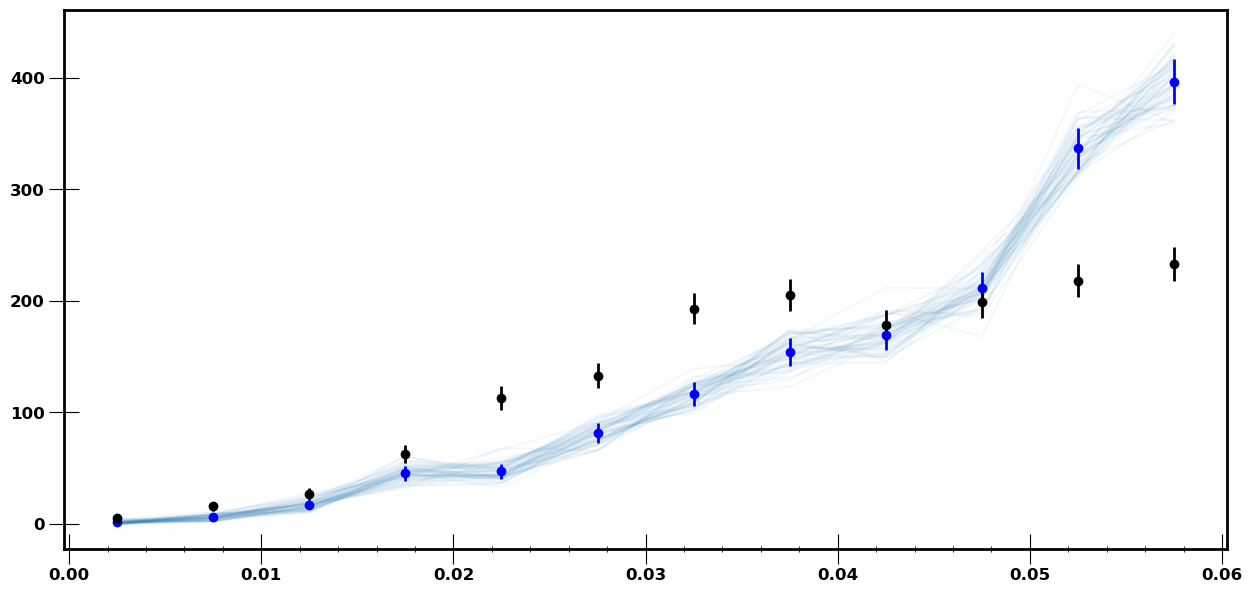

In [27]:
n_draw = 50

samples = [pandas.DataFrame(rand_positions(halos,
                                           size=len(vol_lim_ztf),
                                           weights=halos.M200c,
                                           zcut=0.06)).T
            for k in range(n_draw)]
vol_lim_bins = np.arange(0, 0.065, 0.005)
vol_lim_cen = (vol_lim_bins[1:] + vol_lim_bins[:-1])/2
counts = np.array([np.histogram(sample.z, bins=vol_lim_bins)[0] for sample in samples])
plt.figure(figsize=(15, 7))
plt.plot(vol_lim_cen, counts.T, alpha=0.05, color='tab:blue')
# plt.plot(vol_lim_cen, counts.mean(axis=0), color='tab:blue')
plot_ztf(vol_lim_cen, counts.mean(axis=0), color='b', label='simulations')

plot_ztf(ztf_cent_bins[:12], ztf_count_all[:12], label='ZTF DR2 goods')


In [28]:
from scipy.stats import ks_2samp
pvalues = [ks_2samp(vol_lim_ztf.redshift, sample.z).pvalue for sample in samples]

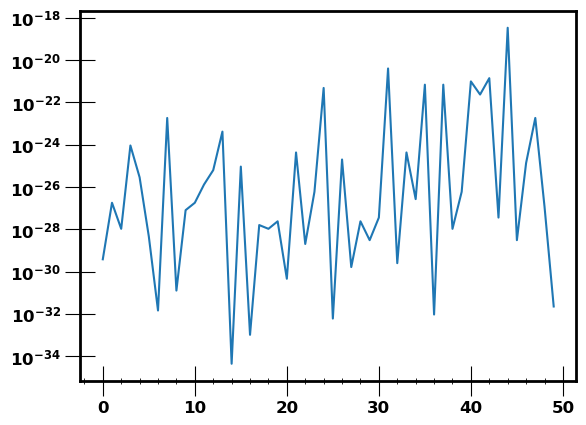

In [29]:
plt.plot(pvalues)
plt.yscale('log')

In [10]:
def sigmoid(x, mlim, slim):
    return 1/(1+np.exp(-(mlim - x)/slim))

In [11]:
mlim, slim = 18.59, 0.25

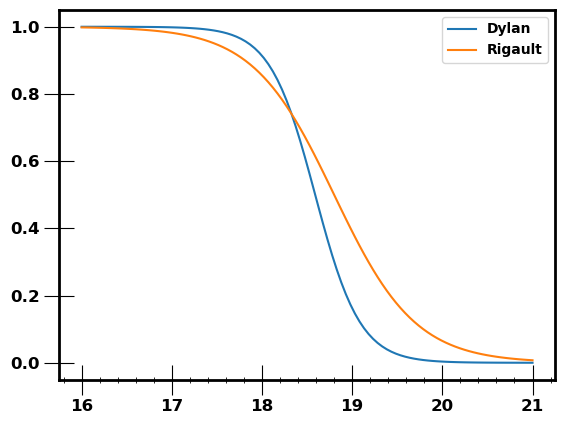

In [44]:
%matplotlib inline
xx = np.linspace(16, 21, 100)
plt.plot(xx, sigmoid(xx, mlim, slim), label='Dylan')
plt.plot(xx, sigmoid(xx, 18.8, 0.45), label='Rigault')
plt.legend()

In [13]:
halos = pandas.read_csv("./data/reduced_hbt/halos_highres_0.csv", index_col=0)

Text(0.5, 0, '$z$')

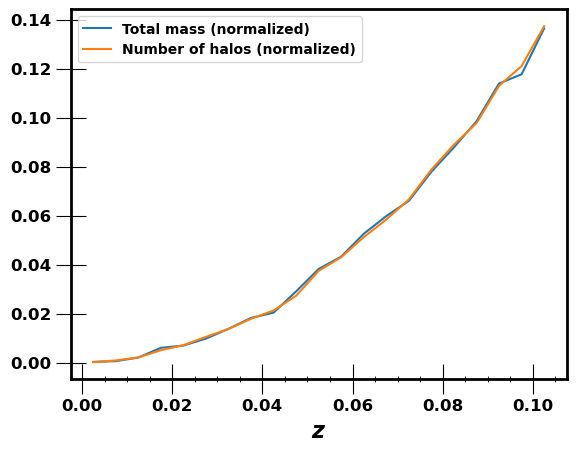

In [14]:
idx = halos.z.argsort()
to_bin = halos.z[idx]
data = halos.BoundM200Crit[idx]
halos_bins=np.arange(0, 0.11, 0.005)
bounds=np.concatenate((
    to_bin.searchsorted(halos_bins[:-1], 'left'),
    to_bin.searchsorted(halos_bins[-1:], 'right')))
mass = np.array([data[start:stop].sum() for start, stop in zip(bounds[:-1],bounds[1:])])
number = np.array([data[start:stop].count() for start, stop in zip(bounds[:-1],bounds[1:])])

halos_cen_bins=(halos_bins[:-1]+halos_bins[1:])/2

plt.plot(halos_cen_bins, mass/mass.sum(), label='Total mass (normalized)')
plt.plot(halos_cen_bins, number/number.sum(), label='Number of halos (normalized)')
plt.legend()
plt.xlabel(r"$z$")

<ErrorbarContainer object of 3 artists>

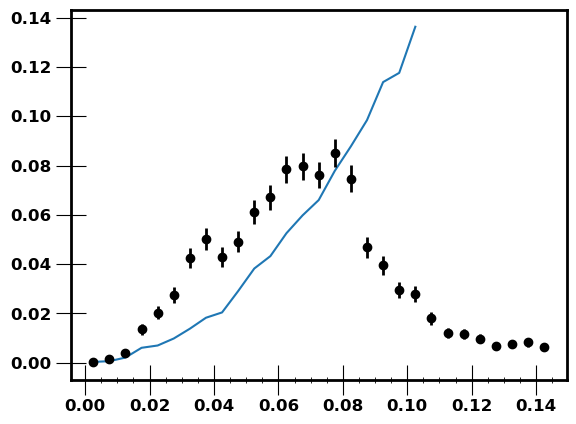

In [15]:
plt.plot(halos_cen_bins, mass/mass.sum(), label='2M++/BORG halo mass')
plt.errorbar(ztf_cent_bins, ztf_count/ztf_count.sum(),
             yerr=np.sqrt(ztf_count)/ztf_count.sum(),
             marker='o', color='k', elinewidth=2, linestyle='', label='ZTF DR2')


In [ ]:
class SNeIa_full_bgs(Transient):

    _KIND = "SNIa"
    _RATE = 2.35 * 10**4 # /yr/Gpc^3 Perley 2020
    _COSMOLOGY = Planck15

    def __init__(self,
                 path=None,
                 filename="Uchuu.csv",
                 salt_path=None,
                 date_range=[58179, 59215],
                 zmax=0.06,
                 extinction=True):
        super().__init__()
        # {'model': func, 'prop': dict, 'input':, 'as':}
        self.galaxy_positions = load_bgs(path=path, filename=filename)
        self.set_model(dict(
            x1={"func": SNeIaStretch.nicolas2021},
            c={"func": SNeIaColor.intrinsic_and_dust},
            t0={"func": np.random.uniform, "kwargs": {"low": date_range[0], "high": date_range[1]}},
            magabs={
                "func": SNeIaMagnitude.tripp1998,
                "kwargs": {"x1": "@x1", "c": "@c", "mabs": -19.3, "sigmaint": 0.10},
            },
            magobs={
                "func": "magabs_to_magobs",  # defined in Target (mother of Transients)
                "kwargs": {"z": "@z_cosmo", "magabs": "@magabs"},
            },
            x0={
                "func": "magobs_to_amplitude",  # defined in Transients
                "kwargs": {"magobs": "@magobs", "param_name": "x0"},
            },  # because it needs to call sncosmo_model.get(param_name)
            radecz={
                "func": rand_positions,
                "kwargs": {"positions": self.galaxy_positions,
                           'zcut': zmax,
                           'weights': self.galaxy_positions.BoundM200Crit/self.galaxy_positions.BoundM200Crit.sum()
                           },
                "as": ["ra", "dec", "z", "bgs_id", "z_cosmo"],
            },
        ))
        
        if salt_path:
            source = sncosmo.SALT2Source(modeldir=salt_path,
                                         m0file='nacl_m0_test.dat',
                                         m1file='nacl_m1_test.dat',
                                         clfile='nacl_color_law_test.dat')
        else:
            source = sncosmo.get_source('salt2', version='2.4')
        
        if extinction:
            model = sncosmo.Model(source=source, effects=[sncosmo.CCM89Dust()], effect_names=['mw'], effect_frames=['obs'])
            self.set_model({**self.model.model,
                            "mwebv":{"func": milkyway.get_mwebv, "kwargs": {"ra": "@ra", "dec": "@dec"}},})
        else:
            model= sncosmo.Model(source=source)
        self.set_template(model)
        
        self.area=self.get_effective_area()
        # USE THIS AREA WHEN DRAWING TO ACCOUNT FOR THE CATALOG FOOTPRINT
        # e.g. SNeIa_full_bgs().draw(skyarea=SNeIa_full_bgs().area)

    def get_effective_area(self):
        nside = 2**(np.int32(np.log2(np.sqrt(self.galaxy_positions.shape[0]/(10*12))))-1)
        id_bgs = ang2pix(theta=np.pi / 2 - self.galaxy_positions["dec"] * np.pi / 180,
                            phi=self.galaxy_positions["ra"] * np.pi / 180,
                            nside=nside)

        mask = np.zeros(nside2npix(nside), dtype=bool)
        for i in id_bgs:
            mask[i] = True

        return np.sum(mask)*nside2pixarea(nside, degrees=True)


In [17]:
ztf_survey = pandas.read_pickle("./data/ztf_dr2.5.pkl")

In [18]:
snia = SNeIa_full_bgs(filename="./data/reduced_hbt/halos_highres_0.csv", zmax=z_max, date_range=ztf_survey.date_range)

2025-05-06 15:39:14 INFO ZTFxUchuu - Found .csv file at ./data/reduced_hbt/halos_highres_0.csv with columns Index(['BoundM200Crit', 'HostHaloId', 'RmaxComoving', 'pos_x', 'pos_y',
       'pos_z', 'vx', 'vy', 'vz', 'd_c', 'vpec', 'z_cosmo', 'z', 'ra', 'dec'],
      dtype='object')


In [19]:
data = snia.draw(tstart=ztf_survey.date_range[0], tstop=ztf_survey.date_range[1], skyarea=snia.area, zmax=z_max, inplace=True)

2025-05-06 15:39:14 WARNING py.warnings - /home/okc/anaconda3/envs/lemaitre/lib/python3.12/site-packages/skysurvey/target/core.py:1001: UserWarning: skyarea given but no model have skyarea as parameters. This is ignored.
  warnings.warn("skyarea given but no model have skyarea as parameters. This is ignored.")



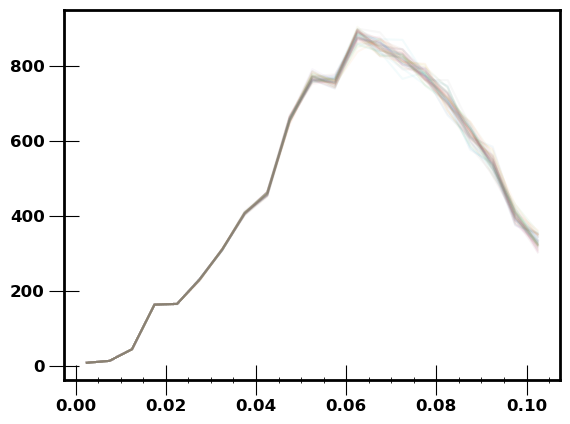

In [53]:
mocks=[(np.random.uniform(0, 1, len(data)) < sigmoid(data.magobs, mlim, slim)) for i in range(50)]

mocks_counts=[]
for sel in mocks:
    count,_ = np.histogram(data.z[sel],
                           bins=halos_bins,
                        #    density=True,
                           )
    plt.plot(halos_cen_bins, count, alpha=0.05)
    mocks_counts.append(count)


In [ ]:
mock_count,_ = np.histogram(data[data.selection].z, halos_bins)

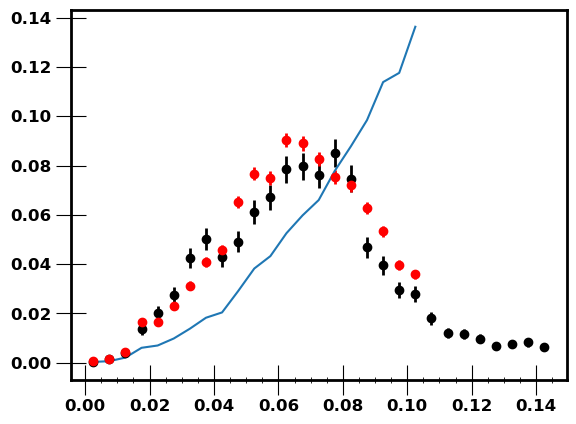

In [50]:
plt.errorbar(ztf_cent_bins, ztf_count/ztf_count.sum(),
             yerr=np.sqrt(ztf_count)/ztf_count.sum(),
             marker='o', color='k', elinewidth=2, linestyle='', label='ZTF DR2')
plt.errorbar(halos_cen_bins, mock_count/mock_count.sum(),
             yerr=np.sqrt(mock_count)/mock_count.sum(),
             marker='o', color='r', elinewidth=2, linestyle='', label='ZTF DR2')
plt.plot(halos_cen_bins, mass/mass.sum(), label='2M++/BORG halo mass')


In [ ]:
dset=skysurvey.DataSet.from_targets_and_survey(snia, ztf_survey)

2025-05-06 15:19:14 WARNING py.warnings - /home/okc/anaconda3/envs/lemaitre/lib/python3.12/site-packages/ztffields/projection.py:151: UserWarning: you don't have dask-geopandas, you have more than 20_000 fields, this would be faster with dask-greopandas
  warnings.warn("you don't have dask-geopandas, you have more than 20_000 fields, this would be faster with dask-greopandas")



In [ ]:
samples = []
for i in tqdm(range(50)):
    # snia = SNeIa_full_bgs(filename=f"./data/reduced_hbt/halos_highres_{i}.csv", zmax=z_max)
    data = snia.draw(tstart=58174, tstop=59225, skyarea=snia.area, zmax=z_max)
    data["selection"] = (np.random.uniform(0, 1, len(data)) < sigmoid(data.magobs, mlim, slim))
    samples.append(data)
    # data.to_csv(f'./data/50_2M++/{i}.csv')
    # del snia, data

  0%|          | 0/50 [00:00<?, ?it/s]

2025-04-15 14:47:36 WARNING py.warnings - /home/okc/anaconda3/envs/lemaitre/lib/python3.12/site-packages/skysurvey/target/core.py:1001: UserWarning: skyarea given but no model have skyarea as parameters. This is ignored.
  warnings.warn("skyarea given but no model have skyarea as parameters. This is ignored.")

2025-04-15 14:47:37 WARNING py.warnings - /home/okc/anaconda3/envs/lemaitre/lib/python3.12/site-packages/skysurvey/target/core.py:1001: UserWarning: skyarea given but no model have skyarea as parameters. This is ignored.
  warnings.warn("skyarea given but no model have skyarea as parameters. This is ignored.")

2025-04-15 14:47:37 WARNING py.warnings - /home/okc/anaconda3/envs/lemaitre/lib/python3.12/site-packages/skysurvey/target/core.py:1001: UserWarning: skyarea given but no model have skyarea as parameters. This is ignored.
  warnings.warn("skyarea given but no model have skyarea as parameters. This is ignored.")

2025-04-15 14:47:37 WARNING py.warnings - /home/okc/anaconda3

In [ ]:
# samples = [pandas.read_csv(f"./data/50_2M++/{i}.csv") for i in tqdm(range(50))]

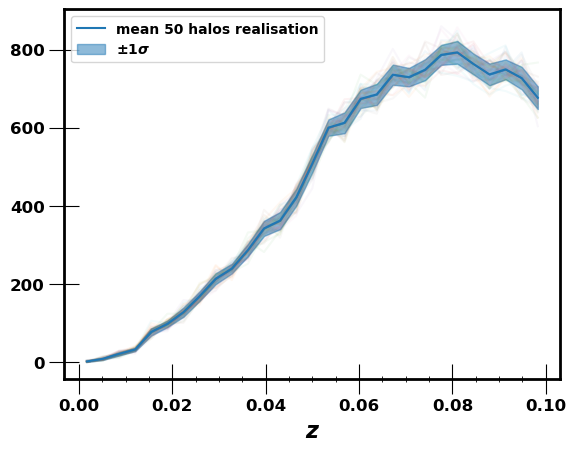

In [ ]:
all_counts = []
n_bins=30
bin_edges = np.linspace(0,0.1, n_bins)
middles = (bin_edges[:-1] + bin_edges[1:])/2
for data in samples:
    count,_ = np.histogram(data.z[data.selection],
                           bins=bin_edges,
                        #    density=True,
                           )
    plt.plot(middles, count, alpha=0.05)
    all_counts.append(count)
plt.plot(middles, np.mean(all_counts, axis=0), label='mean 50 halos realisation')
plt.fill_between(middles, np.mean(all_counts, axis=0), np.mean(all_counts, axis=0) + np.std(all_counts, axis=0), color='tab:blue', alpha=0.5, label=r'$\pm 1 \sigma$')
plt.fill_between(middles, np.mean(all_counts, axis=0), np.mean(all_counts, axis=0) - np.std(all_counts, axis=0), color='tab:blue', alpha=0.5)
plt.xlabel('$z$')
plt.legend()
# plt.savefig('../../SN_density_50_mocks.png')

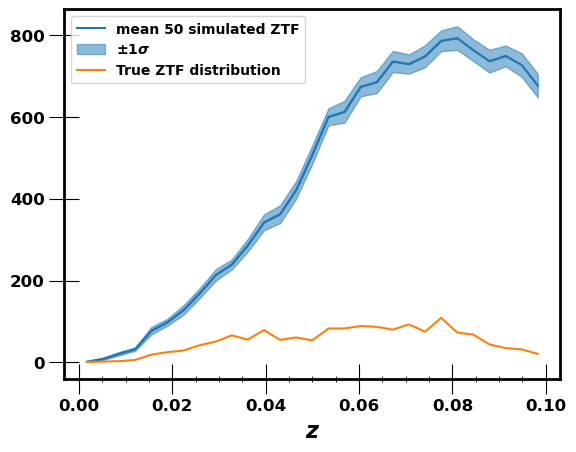

In [ ]:
bin_edges = np.linspace(0,0.1, n_bins)
middles = (bin_edges[:-1] + bin_edges[1:])/2

plt.plot(middles, np.mean(all_counts, axis=0), label='mean 50 simulated ZTF')
plt.fill_between(middles, np.mean(all_counts, axis=0), np.mean(all_counts, axis=0) + np.std(all_counts, axis=0), color='tab:blue', alpha=0.5, label=r'$\pm 1 \sigma$')
plt.fill_between(middles, np.mean(all_counts, axis=0), np.mean(all_counts, axis=0) - np.std(all_counts, axis=0), color='tab:blue', alpha=0.5)
plt.xlabel('$z$')

ztf_bins = np.linspace(0,0.1, 30)
ztf_middles = (ztf_bins[:-1] + ztf_bins[1:])/2

ztf_count, _ = np.histogram(ztf.redshift[ztf.valid],
                            bins=ztf_bins,
                            # density=True,
                            )
# n=2
# plt.plot(middles, filtfilt([1]*n, n, ztf_count))
plt.plot(ztf_middles, ztf_count, label='True ZTF distribution')
plt.legend()
# plt.savefig('../../SN_density_50_mocks_real_data.png')

In [ ]:
shell = snia.galaxy_positions[snia.galaxy_positions.z.between(0., 0.06)]

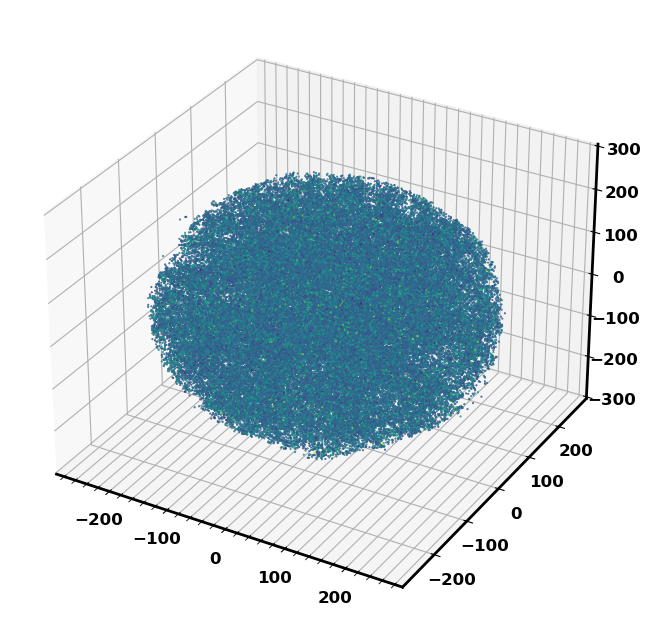

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(8,8), subplot_kw=dict(projection='3d'))
ax.scatter(shell.pos_x, shell.pos_y, shell.pos_z, marker='.', s=1, c=shell.BoundM200Crit, alpha=1., norm='log')

In [ ]:
%matplotlib inline
plt.close()

In [ ]:
rotated=[]
for rot in tqdm(np.linspace(0, 180, 100)*np.pi/180):
    rotated.append(np.array([[1, 0, 0], [0, np.cos(rot), -np.sin(rot)], [0, np.sin(rot), np.cos(rot)]]) @ np.array(shell[['pos_x', 'pos_y', 'pos_z']].T))
rotated=np.array(rotated)

  0%|          | 0/100 [00:00<?, ?it/s]

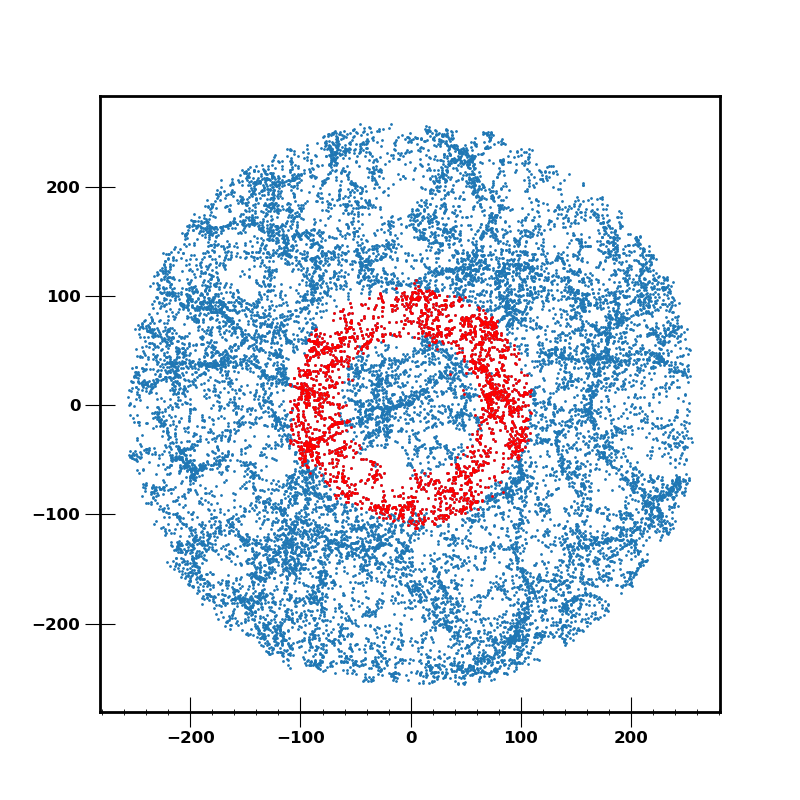

In [ ]:
%matplotlib widget
fig = plt.figure(figsize=(8, 8))
filt = np.abs(rotated[0, 2]) < 30
around_z = 0.02
add_filt = shell.z.between(around_z - 0.005, around_z + 0.005)

set_all = plt.scatter(rotated[0, 0, filt], rotated[0, 1, filt], s=1)
set_z = plt.scatter(shell.pos_x[filt & add_filt].values, shell.pos_y[filt & add_filt].values, s=1, color='red')
plt.show()

In [ ]:
from matplotlib import animation
def update(frame):
    filt = np.abs(rotated[frame][2]) < 30
    set_all.set_offsets(np.vstack([rotated[frame, 0, filt], rotated[frame, 1, filt]]).T)
    set_z.set_offsets(np.vstack([rotated[frame, 0, filt & add_filt], rotated[frame, 1, filt & add_filt]]).T)

ani = animation.FuncAnimation(fig=fig, func=update, frames=rotated.shape[0], interval=100)

In [ ]:
plt.close()

In [ ]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(15,15), subplot_kw=dict(projection='3d'))
ax.scatter(shell.pos_x, shell.pos_y, shell.pos_z, marker='.', s=1, c=shell.BoundM200Crit, alpha=0.1, norm='log')
ax.scatter(shell.pos_x[add_filt], shell.pos_y[add_filt], shell.pos_z[add_filt], marker='.', s=1, color='r', alpha=1., norm='log')

In [ ]:
plt.close()

In [ ]:
file = h5py.File('./data/mcmc_0.hdf5', 'r')
density = np.array(file['density'])

In [ ]:
nside=64
shell = snia.galaxy_positions[snia.galaxy_positions.z.between(0.0, 0.05)]
idx = healpy.ang2pix(nside, shell.ra, shell.dec, lonlat=True)

In [ ]:
m = np.zeros(healpy.nside2npix(nside))
idx = pandas.DataFrame(idx.index, index=idx.values, columns=['halos'])
for id in np.unique(idx.index):
    m[id] += len(idx.loc[id])


In [ ]:
plt.hist(shell.z)

(array([  171.,   651.,  1481.,  3215.,  4607.,  6698.,  8559., 11213.,
        13213., 16934.]),
 array([0.00068986, 0.00562087, 0.01055189, 0.0154829 , 0.02041392,
        0.02534493, 0.03027594, 0.03520696, 0.04013797, 0.04506898,
        0.05      ]),
 <BarContainer object of 10 artists>)

In [ ]:
cosmo.luminosity_distance(0.015)

<Quantity 66.79264905 Mpc>

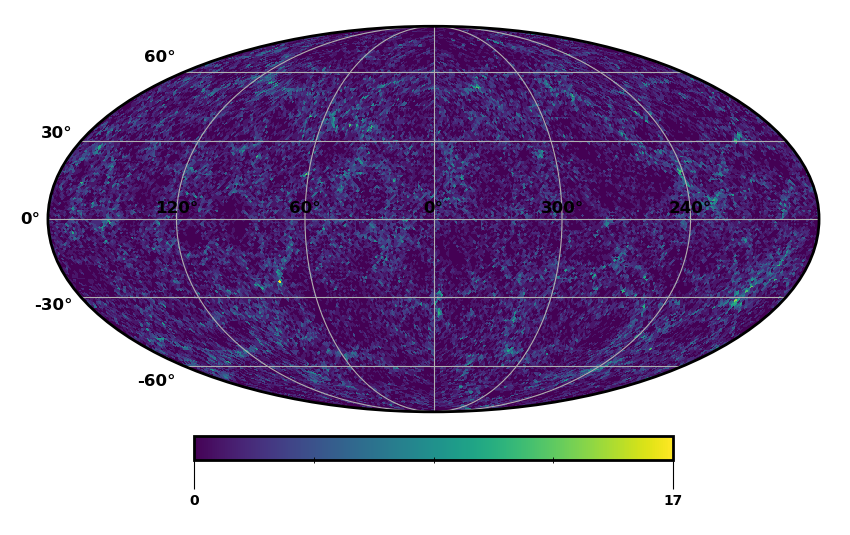

In [ ]:
healpy.projview(m, graticule=True, graticule_labels=True)

In [ ]:
monop, dip = healpy.fit_dipole(m)
print(monop, dip)

0.29105631510416663 [-0.00923277  0.00244403  0.02037951]


In [ ]:
healpy.vec2ang(dip, lonlat=True)

(array([165.17316698]), array([64.89006303]))

In [ ]:
m_rm_dip = healpy.pixelfunc.remove_dipole(m)

2025-04-10 16:09:19 INFO healpy - monopole: 0.29  dipole: lon: 1.7e+02}, lat: 65}, amp: 0.023
